The data provided in this github repository and the following notes aim to allow the reader of the paper "Multi-resolution approach to condition categorical multiple-point realizations to dynamic data with iterative ensemble smoothing" (https://doi.org/10.1029/2019WR025875) to reproduce the figures of the test cases 'A' and 'B'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pl
import processmends as mends
import mpstool
import os 

### Access case directory

In [2]:
pathToCaseDirectory = 'case_a'
#pathToCaseDirectory = 'case_b'
#pathToCaseDirectory = 'case_b-HDNearObs'
os.chdir(pathToCaseDirectory)

# Model setup
## Training image

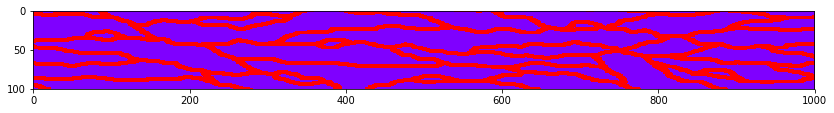

In [3]:
ti = np.flipud(np.reshape(np.loadtxt('ti1000x100.txt'), (100,1000)))
plt.figure(figsize = (14,10))
plt.imshow(ti, cmap='rainbow')

## Simulated reference (case 'A' or cases 'B')

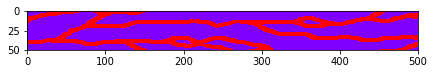

In [4]:
ref = np.flipud(np.reshape(np.loadtxt('ref.txt'), (50,500)))
plt.figure(figsize = (7,5))
plt.imshow(ref, cmap='rainbow')            

## Synthetic data set (hydraulic heads and flow rates)

/home/lamd/mends_testcases/processmends.py:189: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  axarr[i,j].set_ylim(0, np.max(qObsByLoc[:, k])*1.1)


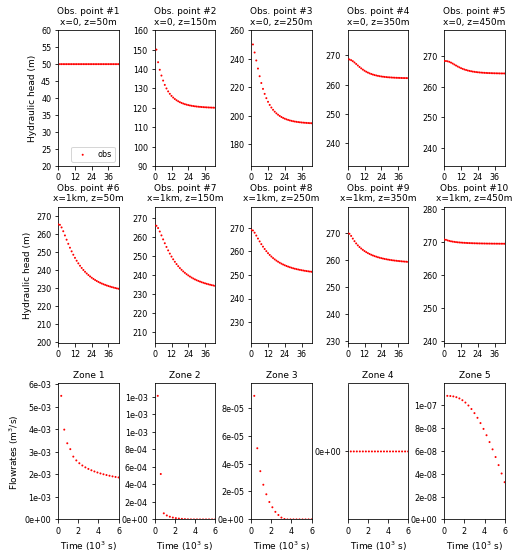

In [5]:
mends.HQ_obs()

# Ensemble Data Assimilation in a Multiresolution MPS framework

- Variables related to the Ensemble Kalman method

In [6]:
ensembleSize = 100
lastIteration = 16 # total number of predefined ES-MDA iterations

if pathToCaseDirectory == 'case_a':
    criticalLength = 160 # in grid blocks. Corresponds to the horizontal extent of the update starting from the western boundary 
else:
    criticalLength = 280 # for the two variants of case b    

- Variables related to the parameters used to define the pyramid structure (number of pyramid levels, factor of reduction in each direction, etc.)

In [7]:
# Grid dimensions at the coarsest scale (scale of the update) and finest scale (scale of the flow simulation)
coarsestGridDim_x = 125
coarsestGridDim_y = 13
finestGridDim_x = 500
finestGridDim_y = 50 

## Conditional Multiresolution MPS simulations  

### Defining the hard conditioning point locations at the coarsest scale

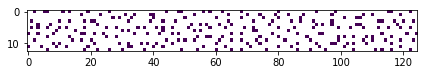

In [8]:
i_HD = np.loadtxt('sampledCells_xCoord.txt').astype(int)
j_HD = np.loadtxt('sampledCells_yCoord.txt').astype(int)

coarseGrid = np.ones((coarsestGridDim_y, coarsestGridDim_x))
coarseGrid[:,:] = np.nan # fill coarse grid with NaN values
coarseGrid[i_HD,j_HD] = 1 # replace NaN value by 1 at hard conditioning point locations

HDLocations = np.ma.array(coarseGrid)
plt.figure(figsize = (7,5))
plt.imshow(HDLocations)

### Updating the values at the hard conditioning points 
- Illustration of the benefit of updating points instead of the whole coarsest field: "connected" instead of "broken" structures

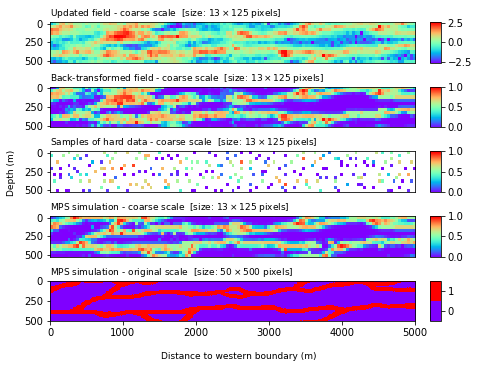

In [9]:
iteration = 8 # must be greater than zero
rank_ensMember = 11
mends.updatedCoarseVar_multiresoMPS(iteration, rank_ensMember, coarsestGridDim_y, coarsestGridDim_x, finestGridDim_y, finestGridDim_x)

## Evolution of the Data Mismatch

- A global decrease of the data mismatch for all ensemble members

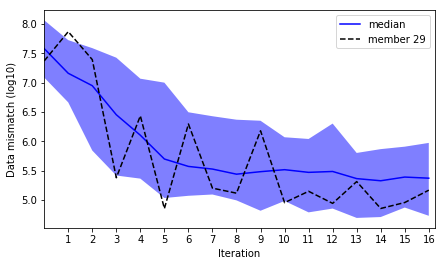

In [10]:
rank_ensMember = 29
mends.dataMismatchWithIteration_95pc(ensembleSize, rank_ensMember, int(lastIteration)) 

- Predicted ensemble before (in gray) and after (in blue) data assimilation

/home/lamd/mends_testcases/processmends.py:275: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  axarr[i,j].set_ylim(0, np.max(qObsByLoc[:, k])*1.1)


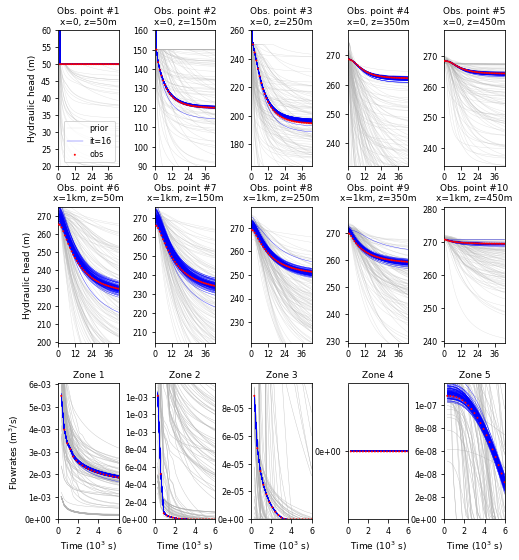

In [11]:
mends.HQ_priorPostEns(lastIteration, 100)

## Identification of the Categorical Fields
- Generated conditional categorical fields for 4 ensemble members after ES-MDA iteration 1, 2, 3, 4, 8, 12, 16. The reference field is shown at the bottom.

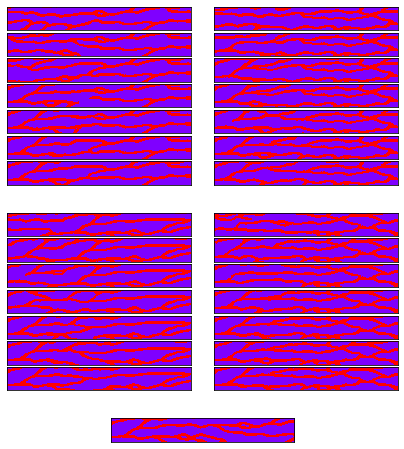

In [12]:
mends.conditionedCategoricalFields_4members(11,59,64,91)

- Range of connectivity function values of the channel facies computed for all categorical fields before and after the data assimilation

In [13]:
# Compute connectivity function in the horizontal direction (axis=1) of the channel facies (category=1) in the reference field

ref = np.flipud(np.reshape(np.loadtxt('ref.txt') , (finestGridDim_y,finestGridDim_x)))
categories = mpstool.connectivity.get_categories(ref)
ref_connectivity = mpstool.connectivity.get_function(ref, axis=1) 
connectFunEns_ini, connectFunEns_fin = mends.ensembleOfConnectFunc(ensembleSize, finestGridDim_x, finestGridDim_y, axis=1, category=1)

q = [25,50,75]
connectFunEns_ini_q = np.percentile(connectFunEns_ini, q=q, axis=1)
connectFunEns_fin_q = np.percentile(connectFunEns_fin, q=q, axis=1)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

colors=pl.cm.Blues(np.linspace(0.2,0.8,2))

axs[0].plot(ref_connectivity[1], color='r') 
axs[0].fill_between(np.arange(finestGridDim_x-1), connectFunEns_ini_q[0], connectFunEns_ini_q[2], facecolor='grey', alpha=0.2)
axs[0].plot(np.arange(finestGridDim_x-1), connectFunEns_ini_q[1], c='blue', label='median')

fig.canvas.draw()
axs[0].set_ylim([0,1])
axs[0].set_xticks([0,99,199,299,399,499])
xlabels = [item.get_text() for item in axs[0].get_xticklabels()]
print(xlabels)
axs[0].set_title('(a)', loc='left', fontsize=10)
axs[0].set_ylabel('Connectivity of channels', fontsize=10)
xlabels[0] = '0'
xlabels[1] = '1000'
xlabels[2] = '2000'
xlabels[3] = '3000'
xlabels[4] = '4000'
xlabels[5] = '5000'
axs[0].set_xticklabels(xlabels)
axs[0].set_xticklabels([])

axs[1].set_ylim([0,1])
axs[1].fill_between(np.arange(499), connectFunEns_fin_q[0], connectFunEns_ini_q[2], facecolor='blue', alpha=0.3)
axs[1].plot(np.arange(499), connectFunEns_fin_q[1], c='blue', label='median')
axs[1].plot(ref_connectivity[1], color='r') 
axs[1].set_title('(b)', loc='left', fontsize=10)
axs[1].set_ylabel('Connectivity of channels', fontsize=10)
axs[1].set_xlabel('Distance (m)', fontsize=10)
axs[1].set_xticks([0,99,199,299,399,499])
axs[1].set_xticklabels(xlabels)

AttributeError: module 'mpstool' has no attribute 'connectivity'

## Uncertainty reduction

- Probability maps of channels calculated before and at various stages of the data assimilation (after iteration 1, 2, 3, 4, 8, 16). The reference field is shown at the bottom.

In [ ]:
mends.meanMaps_vs_ref(finestGridDim_x, finestGridDim_y)

- Evolution of the RMSE and Ensemble Spread

In [ ]:
# Calculate RMSE and Ensemble Spread at each iteration and store all the values in a list
rmseList = mends.rmse(ensembleSize, criticalLength, lastIteration)
varList = mends.meanVarianceReduction(ensembleSize, criticalLength, lastIteration)

# Plot RMSE and Ensemble Spread 
lastIt=int(lastIteration)
plt.figure(figsize=(7,4))
plt.plot(np.arange(0,lastIt+1), np.asarray(varList)**(1/2), linestyle="--", alpha=0.4, label='Ensemble Spread')
plt.plot(np.arange(0,lastIt+1), rmseList, c='r', alpha=0.4, label='RMSE')

axes = plt.gca()
handles, labels = axes.get_legend_handles_labels()
plt.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc="upper right", fontsize=10)
plt.xlabel('Iteration',fontsize=10)

## Uncertainty analysis (only for case 'A')

### Comparing the reduced uncertainty after data assimilation with an uncertainty estimate calculated by Rejection Sampling
- Probability map obtained after rejection sampling


In [ ]:
if pathToCaseDirectory == 'case_a':
    probaMap_rejection = np.flipud(np.reshape(np.mean(np.loadtxt('rejectionSampling_posteriorDist.txt'), axis=1), (50,500)))
    plt.figure(figsize = (7,5))
    plt.imshow(probaMap_rejection, cmap='rainbow')

- Calculating at each iteration the KL divergence between the categorical ensemble distribution and the distribution obtained by rejection sampling (reference distribution) and comparing it to the Shannon Entropy of the categorical ensemble distribution

In [ ]:
if pathToCaseDirectory == 'case_a':
    KLD_list = mends.relativeEntropy_trueDist(ensembleSize, criticalLength, lastIteration)
    SEntropy_list = mends.shannonEntropy(ensembleSize, criticalLength, lastIteration)
    
    plt.figure(figsize=(7,4))
    plt.plot(np.arange(0,lastIt+1), SEntropy_list, linestyle="--", alpha=0.4, label='Shannon entropy')
    plt.plot(np.arange(0,lastIt+1), KLD_list, c='r', alpha=0.4, label='KL divergence')

    axes = plt.gca()
    handles, labels = axes.get_legend_handles_labels()
    plt.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc="upper right", fontsize=10)
    plt.xlabel('Iteration',fontsize=10)
    plt.savefig('KLdiv_VS_shannonEntropy.png', bbox_inches="tight", dpi=300)